## Predicting Employee Attrition    

In recent years, attention has increasingly been paid to human resources (HR), since worker quality and skills represent a growth factor and a real competitive advantage for companies. After proving its mettle in sales and marketing, artificial intelligence is also becoming central to employee-related decisions within HR management. Organizational growth largely depends on staff retention. Losing employees frequently impacts the morale of the organization and hiring new employees is more expensive than retaining existing ones. <br>

You are working as a data scientist with HR Department of a large insurance company focused on sales team attrition. Insurance sales teams help insurance companies generate new business by contacting potential customers and selling one or more types of insurance. The department generally sees high attrition and thus staffing becomes a crucial aspect. <br>

To aid staffing, you are provided with the monthly information for a segment of employees for 2016 and 2017 and tasked to predict whether a current employee will be leaving the organization in the upcoming two quarters (01 Jan 2018 - 01 July 2018) or not, given:<br>


1. Demographics of the employee (city, age, gender etc.) <br>
2. Tenure information (joining date, Last Date)<br>
3. Historical data regarding the performance of the employee (Quarterly rating, Monthly business acquired, designation, salary)<br>

#### Train Data


MMMM-YY : Reporting Date (Monthly) <br>
Emp_ID : Unique id for employees<br>
Age : Age of the employee<br>
Gender : Gender of the employee<br>
City : City Code of the employee<br>
Education_Level : Bachelor, Master or College<br>
Salary : Salary of the employee<br>
Dateofjoining : Joining date for the employee<br>
LastWorkingDate : Last date of working for the employee<br>
Joining Designation : Designation of the employee at the time of joining<br>
Designation : Designation of the employee at the time of reporting<br>
Total_Business_Value : The total business value acquired by the employee in a month<br>
(negative business indicates cancellation/refund of sold insurance policies)<br> 
Quarterly Rating : Quarterly rating of the employee: 1,2,3,4 (higher is better)<br>


#### Test Data
Emp_ID : Unique Id for the employees

#### Submission Format

Emp_ID : Employee ID <br>
Target : <br>
0: if the employee does not leave the organization,<br>1: if the employee leaves the organization<br>

#### Evaluation Metric:
The evaluation metric for this competition is macro f1_score

In [183]:
!pip install xgboost

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier as XGBC

from matplotlib.gridspec import GridSpec
from scipy.special import boxcox1p


import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")

In [185]:
train = pd.read_csv("train.csv")
train.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


In [186]:
train.shape

(19104, 13)

### Missing Values

In [187]:
train.isnull().sum()

MMM-YY                      0
Emp_ID                      0
Age                         0
Gender                      0
City                        0
Education_Level             0
Salary                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Designation                 0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [188]:
train.describe()

,Emp_ID,Age,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating
count,19104.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,1415.591133,34.650283,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,810.705321,6.264471,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,1.000000,21.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,710.000000,30.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,1417.000000,34.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,2137.000000,39.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,2788.000000,58.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


In [189]:
train.columns

Index(['MMM-YY', 'Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Designation', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

In [190]:
list(train.Gender.unique())

['Male', 'Female']

In [191]:
list(train["Joining Designation"].unique())

[1, 2, 3, 4, 5]

In [192]:
list(train.Education_Level.unique())

['Master', 'College', 'Bachelor']

In [193]:
list(train.Designation.unique())

[1, 2, 3, 4, 5]

In [194]:
list(train["Quarterly Rating"].unique())

[2, 1, 4, 3]

In [195]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MMM-YY                19104 non-null  object
 1   Emp_ID                19104 non-null  int64 
 2   Age                   19104 non-null  int64 
 3   Gender                19104 non-null  object
 4   City                  19104 non-null  object
 5   Education_Level       19104 non-null  object
 6   Salary                19104 non-null  int64 
 7   Dateofjoining         19104 non-null  object
 8   LastWorkingDate       1616 non-null   object
 9   Joining Designation   19104 non-null  int64 
 10  Designation           19104 non-null  int64 
 11  Total Business Value  19104 non-null  int64 
 12  Quarterly Rating      19104 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


In [196]:
numerical_feature = train.describe(include=["int64"]).columns

print(list(numerical_feature))

['Emp_ID', 'Age', 'Salary', 'Joining Designation', 'Designation', 'Total Business Value', 'Quarterly Rating']


In [197]:
categorical_features = train.describe(include=["object"]).columns

print(list(categorical_features))

['MMM-YY', 'Gender', 'City', 'Education_Level', 'Dateofjoining', 'LastWorkingDate']


Index(['MMM-YY', 'Gender', 'City', 'Education_Level', 'Dateofjoining',
       'LastWorkingDate'],
      dtype='object')


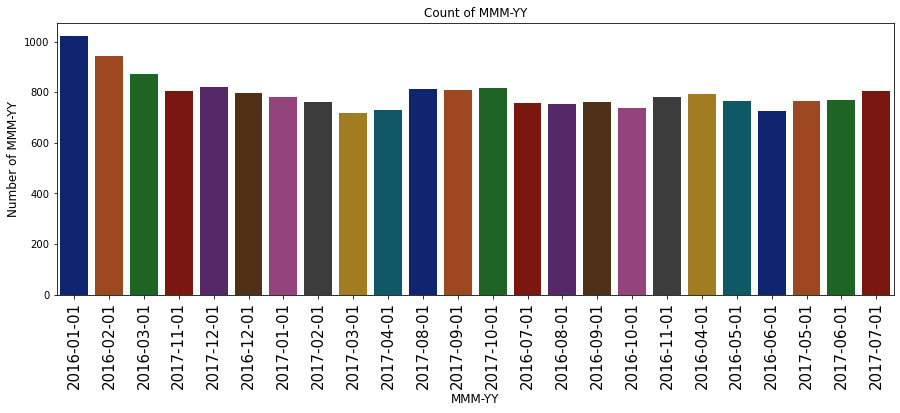

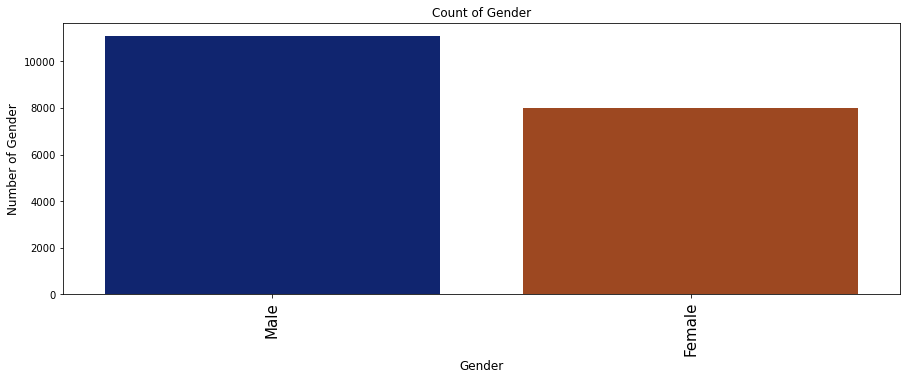

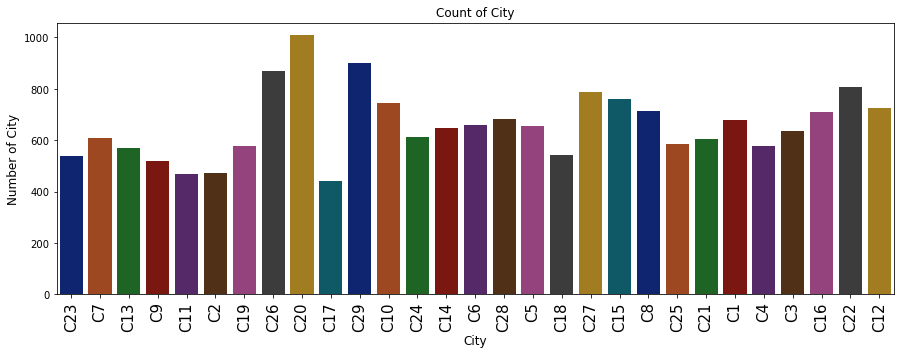

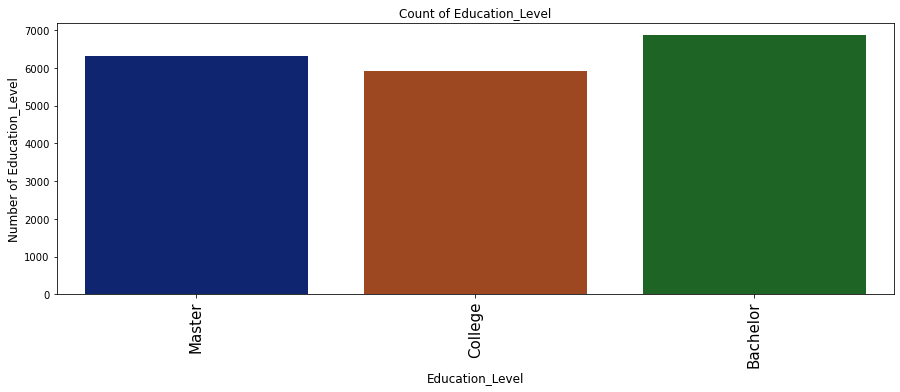

In [198]:
print(categorical_features)



for idx, column in enumerate(categorical_features[:-2]):
    plt.figure(figsize=(15, 5))
    df = train.copy()
    unique = df[column].value_counts(ascending=True);
 
    #plt.subplot(1, len(categorical_features), idx+1)    
    plt.title("Count of "+ column)
    sns.countplot(data=train, x=column,palette = "dark")
    #plt.bar(unique.index, unique.values);
    plt.xticks(rotation = 90, size = 15)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)
    plt.show()

In [199]:
train.columns

Index(['MMM-YY', 'Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Designation', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

Text(0.5, 1.0, 'Monthly Income by Gender')

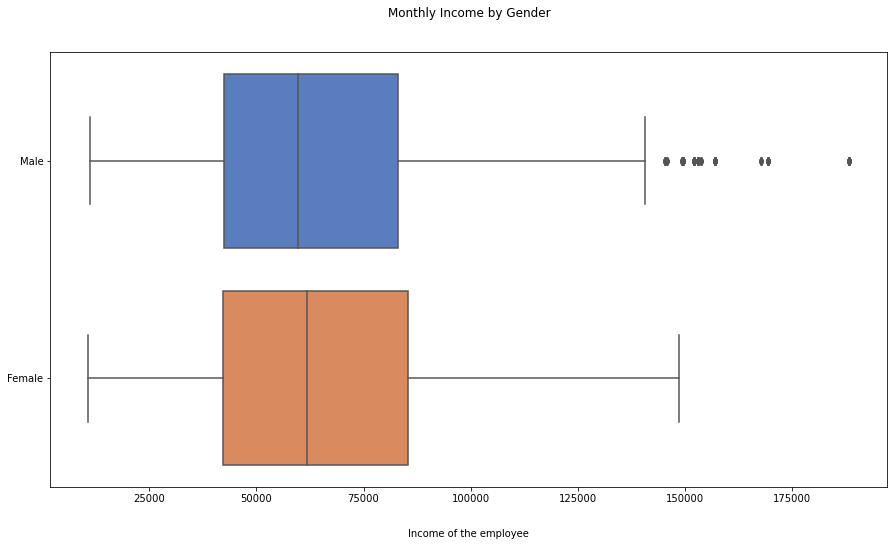

In [200]:
plt.subplots(figsize = (15,8))
ax = sns.boxplot(data = train,
           y = "Gender",
           x = "Salary",
           palette = "muted")

ax.set_xlabel("Income of the employee", labelpad = 25)
ax.set_ylabel(None)
ax.set_title("Monthly Income by Gender", pad = 35)

## Data preprocessing

In [201]:
id= []
for i in train.Emp_ID.unique():
    if len(train[train.Emp_ID ==i].Designation.unique()) >1:
        print(i)
        id.append(i)
    else:
        print(i, ": no designation change")
    
    

1 : no designation change
2 : no designation change
4 : no designation change
5 : no designation change
6 : no designation change
8 : no designation change
11 : no designation change
12 : no designation change
13 : no designation change
14 : no designation change
16 : no designation change
17 : no designation change
18 : no designation change
20 : no designation change
21 : no designation change
22 : no designation change
24 : no designation change
25 : no designation change
26
29 : no designation change
30 : no designation change
31 : no designation change
34 : no designation change
35 : no designation change
36 : no designation change
37 : no designation change
38 : no designation change
39 : no designation change
40 : no designation change
41 : no designation change
42 : no designation change
43 : no designation change
44 : no designation change
45 : no designation change
46 : no designation change
47 : no designation change
49 : no designation change
50 : no designation change
51 :

443 : no designation change
444 : no designation change
445 : no designation change
446 : no designation change
448 : no designation change
449 : no designation change
450 : no designation change
451 : no designation change
452 : no designation change
453 : no designation change
454 : no designation change
456 : no designation change
457 : no designation change
458 : no designation change
459 : no designation change
460 : no designation change
461 : no designation change
462 : no designation change
463 : no designation change
464 : no designation change
465 : no designation change
466 : no designation change
467 : no designation change
469 : no designation change
470 : no designation change
471 : no designation change
472 : no designation change
473 : no designation change
474 : no designation change
475 : no designation change
476 : no designation change
477 : no designation change
478 : no designation change
479 : no designation change
481 : no designation change
482 : no designation

831 : no designation change
832 : no designation change
834 : no designation change
835 : no designation change
836 : no designation change
838 : no designation change
839 : no designation change
840 : no designation change
841 : no designation change
842 : no designation change
843 : no designation change
844 : no designation change
845 : no designation change
847 : no designation change
848 : no designation change
849 : no designation change
850 : no designation change
851 : no designation change
852 : no designation change
853 : no designation change
855 : no designation change
856 : no designation change
858 : no designation change
859 : no designation change
860 : no designation change
863 : no designation change
864 : no designation change
865 : no designation change
866 : no designation change
867 : no designation change
868 : no designation change
869 : no designation change
870 : no designation change
871 : no designation change
872 : no designation change
873 : no designation

1226 : no designation change
1227 : no designation change
1228 : no designation change
1229 : no designation change
1230 : no designation change
1231 : no designation change
1232 : no designation change
1233 : no designation change
1234 : no designation change
1235 : no designation change
1236 : no designation change
1238 : no designation change
1239 : no designation change
1242 : no designation change
1243 : no designation change
1244 : no designation change
1245 : no designation change
1246 : no designation change
1247 : no designation change
1248 : no designation change
1249
1250 : no designation change
1251 : no designation change
1252 : no designation change
1255 : no designation change
1258 : no designation change
1259 : no designation change
1260 : no designation change
1261 : no designation change
1262 : no designation change
1263 : no designation change
1264 : no designation change
1265 : no designation change
1267 : no designation change
1268 : no designation change
1269 : no

1606 : no designation change
1607 : no designation change
1609 : no designation change
1610 : no designation change
1611 : no designation change
1612 : no designation change
1613 : no designation change
1614 : no designation change
1616 : no designation change
1617 : no designation change
1618 : no designation change
1619 : no designation change
1621 : no designation change
1622 : no designation change
1623 : no designation change
1624 : no designation change
1625 : no designation change
1626 : no designation change
1627 : no designation change
1628 : no designation change
1629 : no designation change
1630 : no designation change
1631 : no designation change
1632 : no designation change
1633 : no designation change
1634 : no designation change
1635 : no designation change
1636 : no designation change
1637 : no designation change
1638 : no designation change
1639 : no designation change
1640 : no designation change
1642 : no designation change
1643 : no designation change
1644 : no desi

2007 : no designation change
2008
2009 : no designation change
2010 : no designation change
2012 : no designation change
2013 : no designation change
2014 : no designation change
2015 : no designation change
2016 : no designation change
2017 : no designation change
2018 : no designation change
2019 : no designation change
2020 : no designation change
2021 : no designation change
2022 : no designation change
2023 : no designation change
2024 : no designation change
2025 : no designation change
2026 : no designation change
2027 : no designation change
2028 : no designation change
2030 : no designation change
2031 : no designation change
2032 : no designation change
2033 : no designation change
2034 : no designation change
2035 : no designation change
2036 : no designation change
2037 : no designation change
2038 : no designation change
2039 : no designation change
2040 : no designation change
2041 : no designation change
2043 : no designation change
2044 : no designation change
2045 : no

2400 : no designation change
2402 : no designation change
2403 : no designation change
2404 : no designation change
2405 : no designation change
2406 : no designation change
2407
2408 : no designation change
2409 : no designation change
2410 : no designation change
2411 : no designation change
2412 : no designation change
2413 : no designation change
2414 : no designation change
2415 : no designation change
2416 : no designation change
2417 : no designation change
2418 : no designation change
2419 : no designation change
2420 : no designation change
2421 : no designation change
2422 : no designation change
2423 : no designation change
2424 : no designation change
2425 : no designation change
2426 : no designation change
2427 : no designation change
2428 : no designation change
2429 : no designation change
2430 : no designation change
2431 : no designation change
2432 : no designation change
2433 : no designation change
2435 : no designation change
2436 : no designation change
2438 : no

2787 : no designation change
2788 : no designation change


Employees with change in designations

In [202]:
id

[26,
 54,
 60,
 98,
 275,
 307,
 320,
 368,
 434,
 537,
 568,
 580,
 582,
 638,
 716,
 789,
 888,
 1031,
 1050,
 1161,
 1165,
 1206,
 1249,
 1274,
 1316,
 1327,
 1770,
 1783,
 1817,
 1840,
 1852,
 1877,
 1918,
 2008,
 2070,
 2087,
 2198,
 2272,
 2390,
 2407,
 2543,
 2567,
 2625,
 2690]

In [203]:
city= []
for i in train.Emp_ID.unique():
    if len(train[train.Emp_ID ==i].City.unique()) >1:
        print(i)
        city.append(i)
    

In [204]:
city

[]

No change in the city

In [205]:
train.columns

Index(['MMM-YY', 'Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Designation', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

In [206]:
train['MMM-YY'] = train['MMM-YY'].str.replace('-','/')
train['Dateofjoining'] = train['Dateofjoining'].str.replace('-','/')
train['LastWorkingDate'] = train['LastWorkingDate'].str.replace('-','/')

In [207]:
train[["MMM-YY", "Dateofjoining"]] = train[["MMM-YY", "Dateofjoining"]].apply(pd.to_datetime)

In [208]:
train["LastWorkingDate"] = train["LastWorkingDate"].apply(pd.to_datetime)

In [209]:
train.dtypes

MMM-YY                  datetime64[ns]
Emp_ID                           int64
Age                              int64
Gender                          object
City                            object
Education_Level                 object
Salary                           int64
Dateofjoining           datetime64[ns]
LastWorkingDate         datetime64[ns]
Joining Designation              int64
Designation                      int64
Total Business Value             int64
Quarterly Rating                 int64
dtype: object

In [210]:
train.isnull().sum()

MMM-YY                      0
Emp_ID                      0
Age                         0
Gender                      0
City                        0
Education_Level             0
Salary                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Designation                 0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [211]:
train["LastWorkingDate"].replace({pd.NaT: 0}, inplace=True)

In [212]:
train["LastWorkingDate"] = train["LastWorkingDate"].apply(pd.to_datetime)

## Feature Engineering

In [213]:
len(train.Emp_ID.unique())

2381

In [214]:
# List of all the employee IDs
emp_id = [i for i in train.Emp_ID.unique()]


In [215]:
joined =[]
left=[]
tenure =[]
attrition =[]
no_attrition =[] #for refrence

gender =[]
city=[]
education=[]
joining_de =[]
de=[]

for emp in emp_id:
    joined.append(train[train.Emp_ID ==emp].Age.unique()[0])
    left.append(train[train.Emp_ID ==emp].Age.unique()[-1])
    
    gender.append(train[train.Emp_ID ==emp].Gender.unique()[0])
    city.append(train[train.Emp_ID ==emp].City.unique()[0])
    education.append(train[train.Emp_ID ==emp].Education_Level.unique()[0])
    joining_de.append(train[train.Emp_ID ==emp]["Joining Designation"].unique()[0])
    de.append(train[train.Emp_ID ==emp].Designation.unique()[0])
    
    
    
    if (str(train[train.Emp_ID ==emp].LastWorkingDate.to_list()[-1]) != '1970-01-01 00:00:00') and (str(train[train.Emp_ID ==emp].Dateofjoining.to_list()[-1]) != '1970-01-01 00:00:00'):
        attr_emp = int(str(train[train.Emp_ID ==emp].LastWorkingDate.to_list()[-1] - train[train.Emp_ID ==emp].Dateofjoining.to_list()[-1]).split(" days")[0])
        tenure.append(abs(attr_emp))
        attrition.append(1)
    else:
        #print(emp, " did not leave")
        attrition.append(0)
        no_attr_emp = int(str(train[train.Emp_ID ==emp]["MMM-YY"].to_list()[-1] - train[train.Emp_ID ==emp].Dateofjoining.to_list()[-1]).split(" days")[0])
        tenure.append(abs(no_attr_emp))
        no_attrition.append(emp)
    

In [216]:
promoted =[]
daysSincePromotion =[]
NoofPromotions =[]
not_promoted_ids =[] #for reference


for emp in emp_id:

    if len(train[train.Emp_ID ==emp].Designation.unique())>1:
        # Promotion flag
        promoted.append(1) #yes
        
        NoofPromotions.append(len(train[train.Emp_ID ==emp].Designation.unique()) -1)
        #print(train[train.Emp_ID ==emp].Designation.unique())
        
        
        # Code to find days since last promotion
        #for visualization purpose
        
        idx_pos = train[train.Emp_ID ==emp].Designation ==train[train.Emp_ID ==emp].Designation.unique()[-1]
        #print([train[train.Emp_ID ==emp])
        idx = idx_pos.ne(False).idxmax()
        
        days = train[train.index ==idx]["MMM-YY"].to_list()[-1] - train[train.index ==idx].Dateofjoining.to_list()[-1]
        #print(str(days).split(" days")[0], " days since last promotion")
        daysSincePromotion.append(abs(int(str(days).split(" days")[0])))
        
    else:
        #promotion flag
        not_promoted_ids.append(emp)
        promoted.append(0) #No
        
        NoofPromotions.append(len(train[train.Emp_ID ==emp].Designation.unique()) -1)
        
        #days since last promotion
        #print("No Promotion")
        #print(train[train.Emp_ID ==emp].Designation.unique())
        
        # This just to avoid NaN values
        if (str(train[train.Emp_ID ==emp].LastWorkingDate.to_list()[-1]) != '1970-01-01 00:00:00') and (str(train[train.Emp_ID ==emp].Dateofjoining.to_list()[-1]) != '1970-01-01 00:00:00'):
            daysSincePromotion.append(abs(int(str(train[train.Emp_ID ==emp].LastWorkingDate.to_list()[-1] - train[train.Emp_ID ==emp].Dateofjoining.to_list()[-1]).split(" days")[0])))
        else:
            daysSincePromotion.append(abs(int(str(train[train.Emp_ID ==emp]["MMM-YY"].to_list()[-1] - train[train.Emp_ID ==emp].Dateofjoining.to_list()[-1]).split(" days")[0])))
  
        
        
    

In [217]:
len(no_attrition)/len(emp_id)

0.32129357412851745

In [218]:
# Average performance Rating
ratings= []
for emp in emp_id:
    ratings.append(int(round(train[train.Emp_ID ==emp]["Quarterly Rating"].mean())))

In [219]:
# Salary hike in %
pct_hike =[]
hike =[] #1 :yes
avg_salary = []
for emp in emp_id:
    if len(train[train.Emp_ID ==emp].Salary.unique()) >1:
        hike.append(1)
        pct_hike.append(int(round(((train[train.Emp_ID ==emp].Salary.unique()[-1] -train[train.Emp_ID ==emp].Salary.unique()[0])/(train[train.Emp_ID ==emp].Salary.unique()[0]))*100)))
        avg_salary.append(int(round((train[train.Emp_ID ==emp].Salary.unique()).mean())))
    else:
        hike.append(0)
        pct_hike.append(0)
        avg_salary.append(int(round((train[train.Emp_ID ==emp].Salary.unique()).mean())))

In [220]:
# Need to consider a tenure 

In [221]:
#TODO Visualize
#Tenure promotion ,Days since last promotion, Salary Hike

In [222]:
avg_business_val = []
for emp in emp_id:
    avg_business_val.append(int(round(train[train.Emp_ID ==emp]["Total Business Value"].mean())))
    


In [223]:
list_of_tuples = list(zip(emp_id, joined, left, gender, city, education, tenure, avg_salary, pct_hike, hike, promoted, daysSincePromotion,
                          NoofPromotions, joining_de, de, avg_business_val, ratings, attrition))




In [224]:
df = pd.DataFrame(list_of_tuples,
                  columns = ['emp_id', 'age_joining', 'age_last', 'gender', 'city', 'education',
                             'daysAtcompany', 'average_salary',  'percentage_hike','got_hike',
                            'got_promoted', 'daysSince_promotion', 'noOf_promotions', 'joining_designation',
                            'current_designation', 'avg_business_value', 'ratings', 'attrition']) 

In [225]:
df

,emp_id,age_joining,age_last,gender,city,education,daysAtcompany,average_salary,percentage_hike,got_hike,got_promoted,daysSince_promotion,noOf_promotions,joining_designation,current_designation,avg_business_value,ratings,attrition
0,1,28,28,Male,C23,Master,78,57387,0,0,0,78,0,1,1,571860,2,1
1,2,31,31,Male,C7,Master,25,67016,0,0,0,25,0,2,2,0,1,0
2,4,43,43,Male,C13,Master,141,65603,0,0,0,141,0,2,2,70000,1,1
3,5,29,29,Male,C9,College,58,46368,0,0,0,58,0,1,1,40120,1,1
4,6,31,31,Female,C11,Bachelor,123,78728,0,0,0,123,0,3,3,253000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,33,34,Male,C24,College,1873,82815,0,0,0,1873,0,2,3,906201,3,0
2377,2785,34,34,Female,C9,College,61,12105,0,0,0,61,0,1,1,0,1,1
2378,2786,44,45,Male,C19,College,419,35370,0,0,0,419,0,2,2,312788,2,1
2379,2787,28,28,Female,C20,Master,335,69498,0,0,0,335,0,1,1,162972,2,1


In [226]:
df.columns

Index(['emp_id', 'age_joining', 'age_last', 'gender', 'city', 'education',
       'daysAtcompany', 'average_salary', 'percentage_hike', 'got_hike',
       'got_promoted', 'daysSince_promotion', 'noOf_promotions',
       'joining_designation', 'current_designation', 'avg_business_value',
       'ratings', 'attrition'],
      dtype='object')

## EDA

In [227]:
def factorplot(param):
    sns.factorplot(x =param, size = 7, aspect = 2, data = df, y= "attrition", palette = "dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Attrition Probabilty\n")
    plt.show()
    
def factorplot_bar(param):
    sns.factorplot(x =param, size = 7, aspect = 2, data = df, y= "attrition", kind = "bar",palette = "dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Attrition\n")
    plt.show()
    
def distplot(param):
    plt.figure(figsize=(20,8))
    sns.distplot(df[param], color = "steelblue", hist_kws={"rwidth":0.80, 'alpha':1.0})
    #plt.xticks(np.arange(0,600,10),rotation=45)
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
    
def countplot(feature):
    plt.figure(figsize=(15,8))
    sns.countplot(data=df, x=feature,palette = "dark")
    plt.xlabel('\n' +feature)
    plt.ylabel('Number of Occurrences\n')
    plt.show()


def violineplot(param):
    plt.figure(figsize=(15,8))
    sns.violinplot(y=param,data=df,x='attrition',palette = "dark")
    plt.xlabel('\n'+"attrition")
    plt.ylabel(param+'\n')
    plt.show()
    
def boxplot(x_param, y_param):
    plt.figure(figsize=(15,8))
    sns.boxplot(x=x_param, data=df,y=y_param, palette = "dark")
    plt.xlabel('\n'+ x_param)
    plt.ylabel(y_param + '\n')
    plt.show()

Age at the time of joining and attrition relation

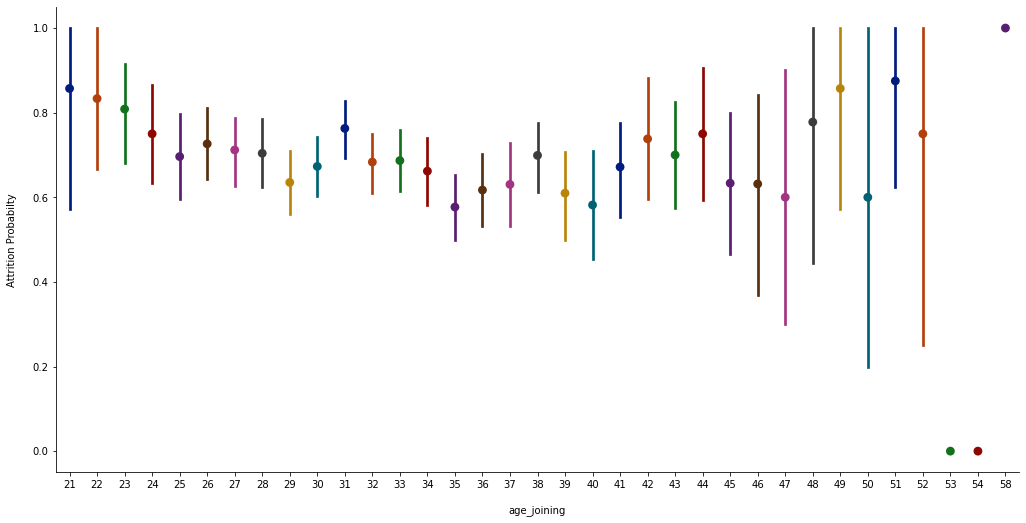

In [228]:
factorplot("age_joining")

Age on last working day

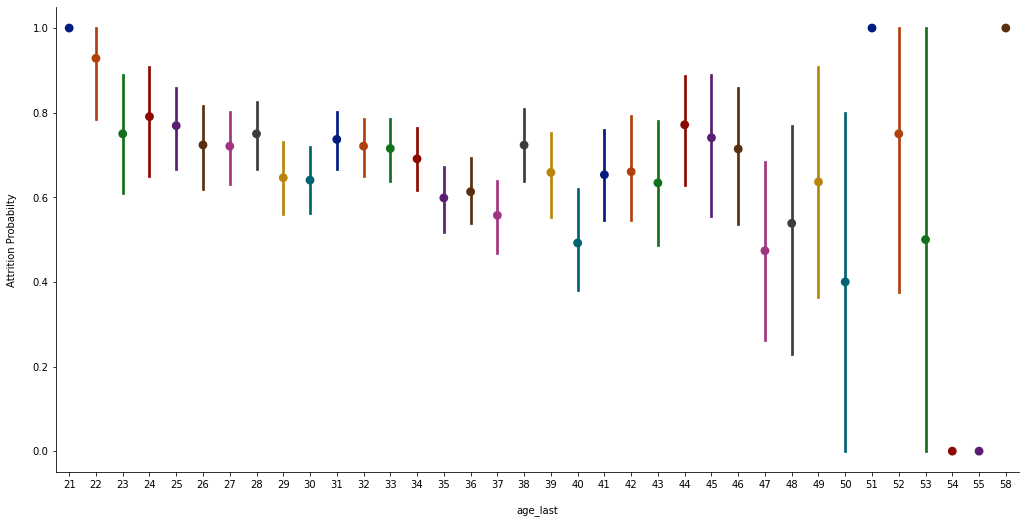

In [229]:
factorplot("age_last")

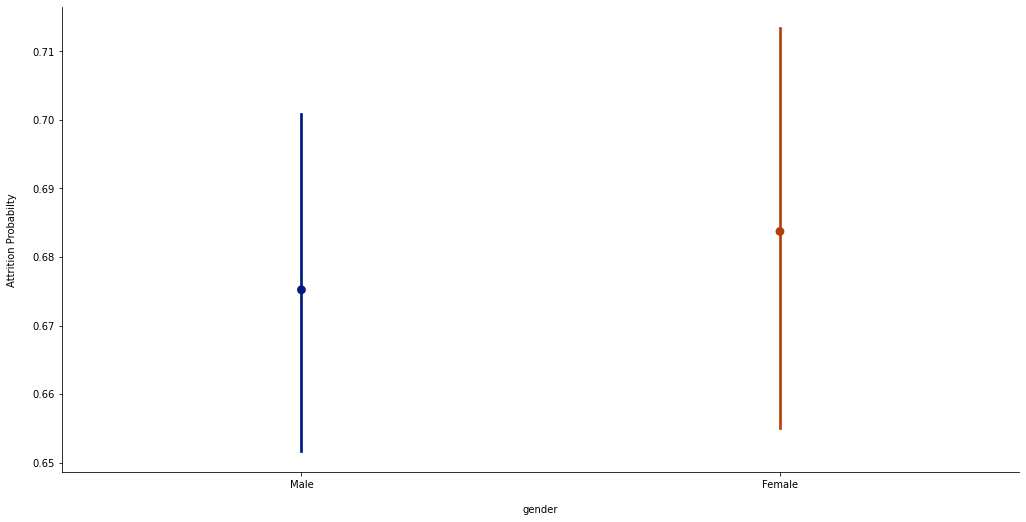

In [230]:
factorplot("gender")

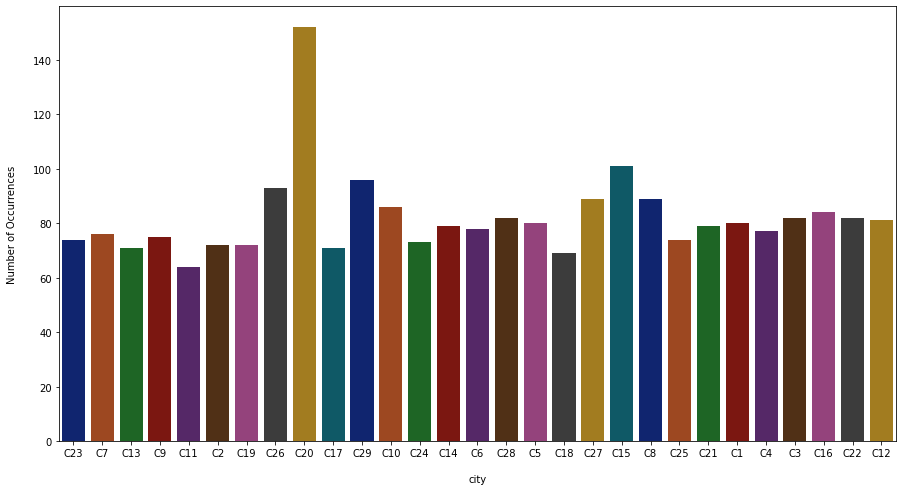

In [231]:
countplot("city")

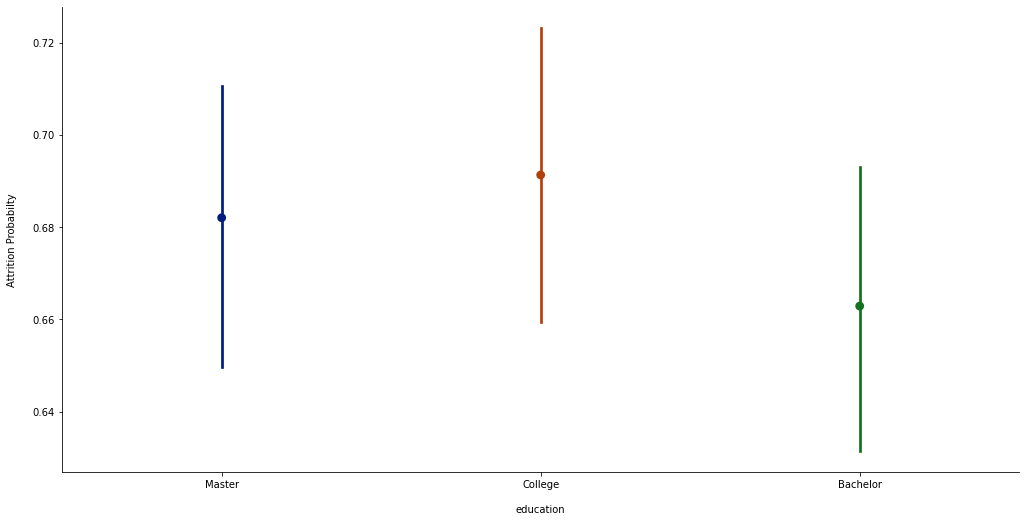

In [232]:
factorplot("education")

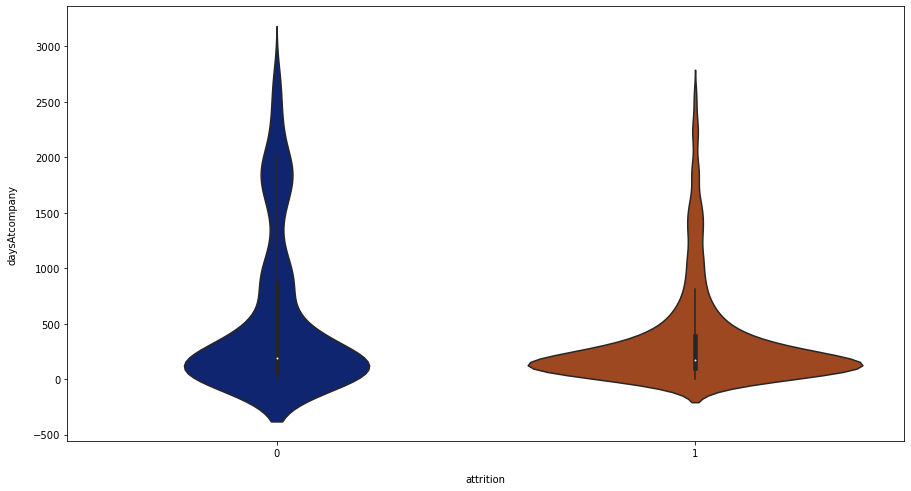

In [233]:
violineplot("daysAtcompany")

In [234]:
df[df.daysAtcompany <=0]

,emp_id,age_joining,age_last,gender,city,education,daysAtcompany,average_salary,percentage_hike,got_hike,got_promoted,daysSince_promotion,noOf_promotions,joining_designation,current_designation,avg_business_value,ratings,attrition
220,264,25,25,Male,C11,Master,0,49439,0,0,0,0,0,1,1,0,1,1
1026,1207,28,28,Male,C24,College,0,56498,0,0,0,0,0,2,2,0,1,1
1344,1581,29,29,Male,C15,College,0,25873,0,0,0,0,0,1,1,0,1,1
2041,2397,38,38,Female,C8,College,0,47818,0,0,0,0,0,2,2,0,1,1


Attrition is high in first 500 days

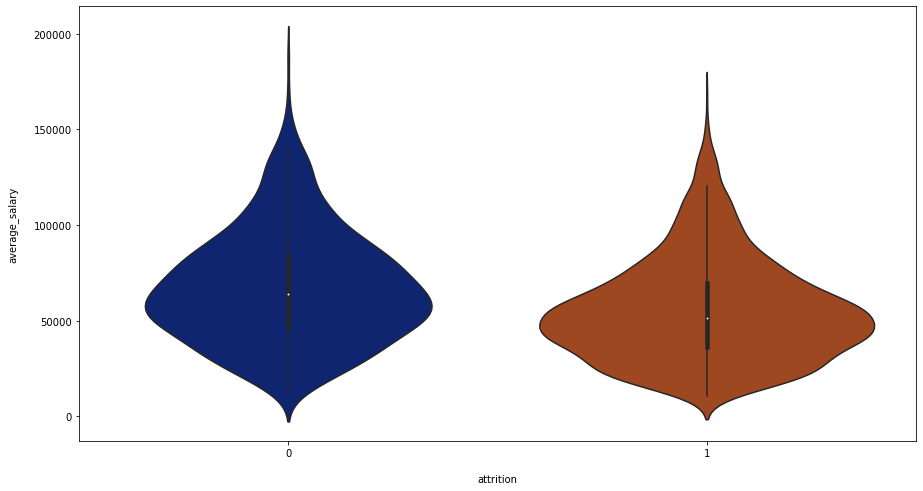

In [235]:
violineplot("average_salary")

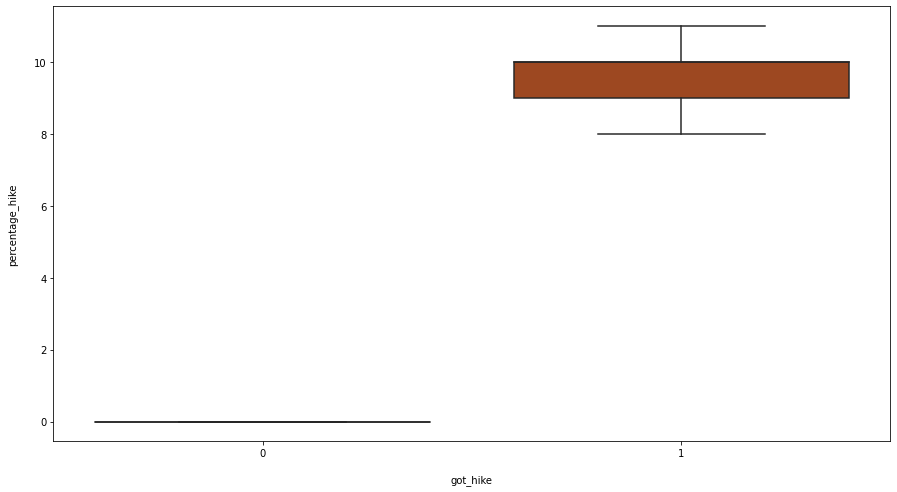

In [236]:
boxplot( "got_hike", "percentage_hike" )

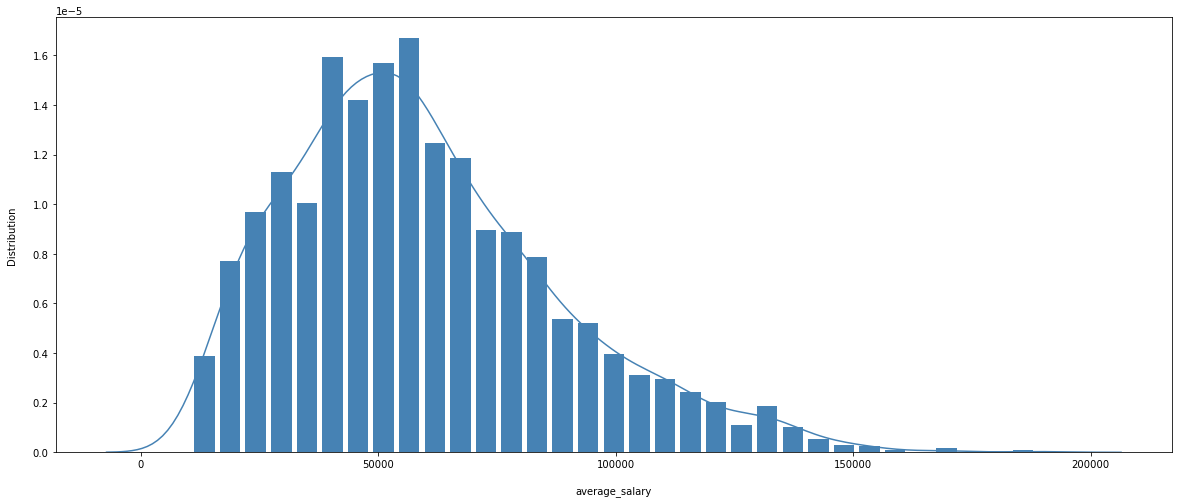

In [237]:
distplot("average_salary")

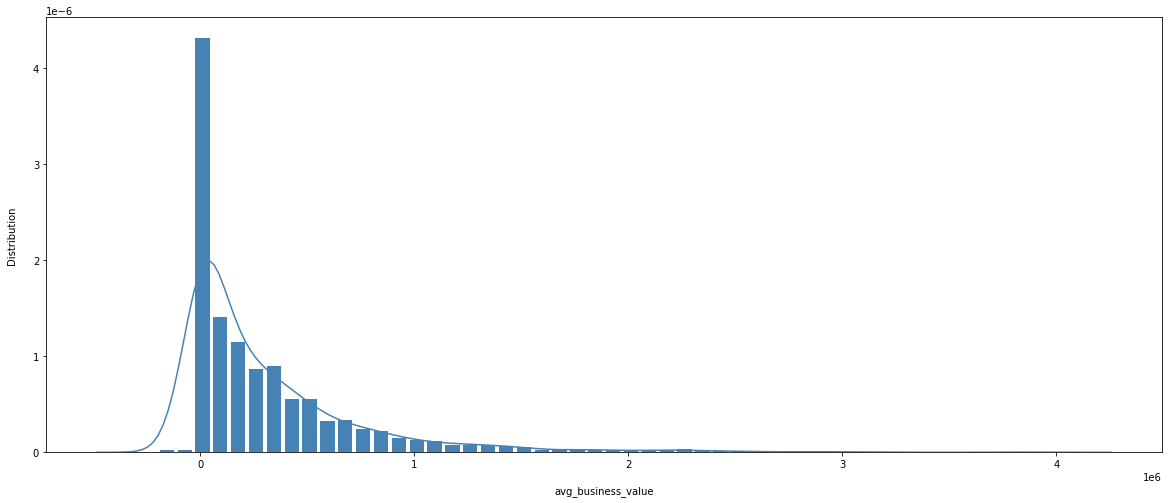

In [238]:
distplot("avg_business_value")

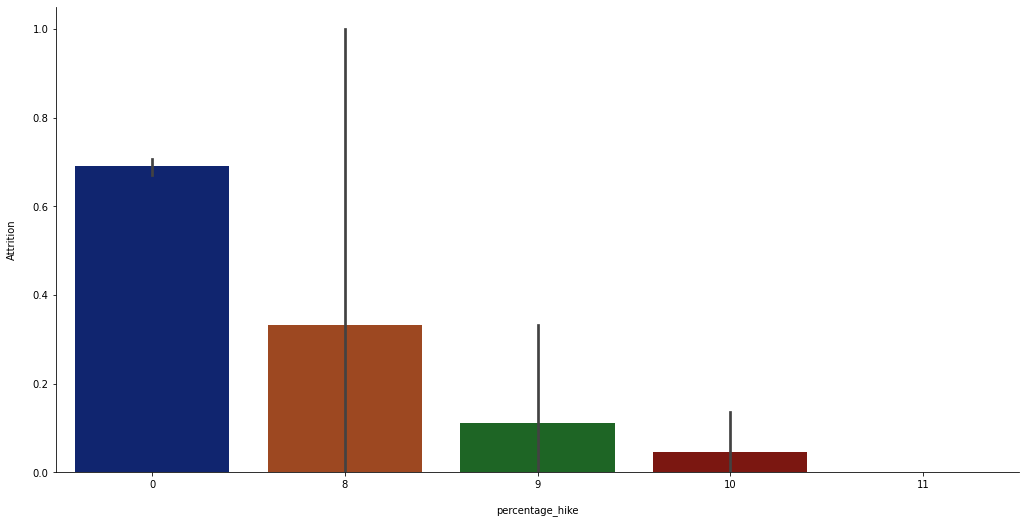

In [239]:
factorplot_bar("percentage_hike")

In [243]:
promotion = df[df.got_promoted ==1]


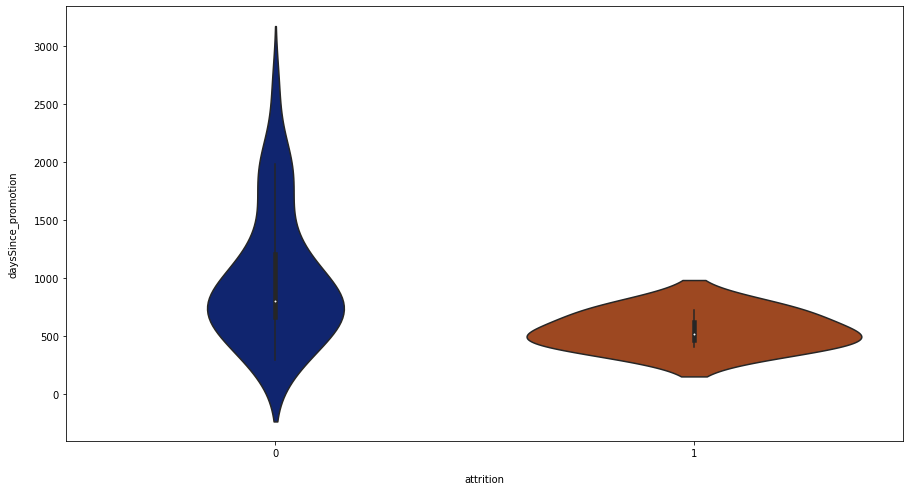

In [244]:
plt.figure(figsize=(15,8))
sns.violinplot(y="daysSince_promotion",data=promotion,x='attrition',palette = "dark")
plt.xlabel('\n'+"attrition")
plt.ylabel("daysSince_promotion"+'\n')
plt.show()



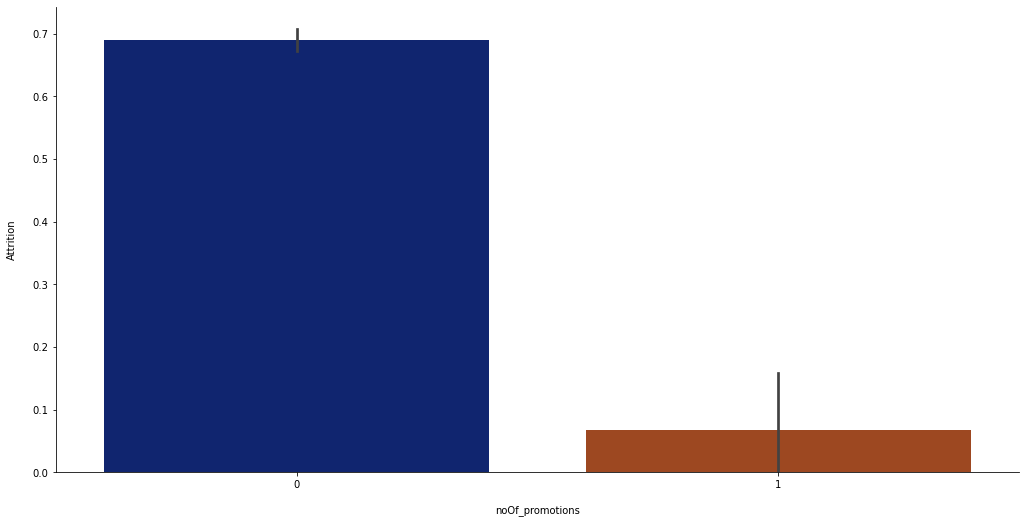

In [245]:
factorplot_bar("noOf_promotions")

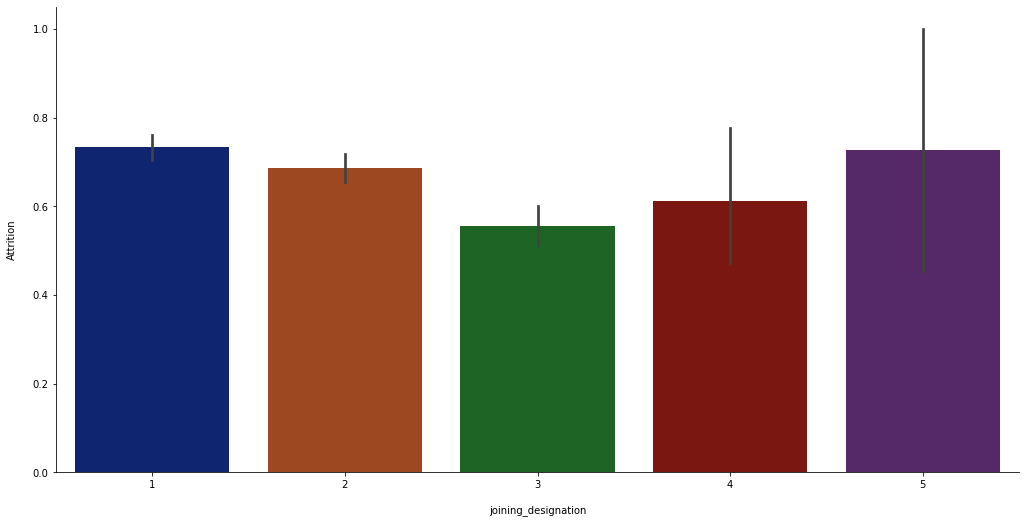

In [246]:
factorplot_bar("joining_designation")

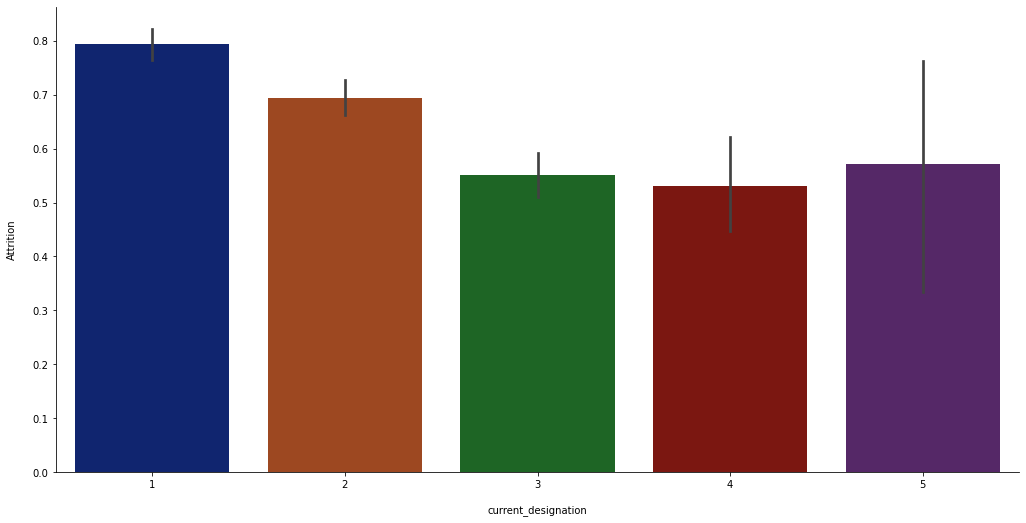

In [247]:
factorplot_bar("current_designation")

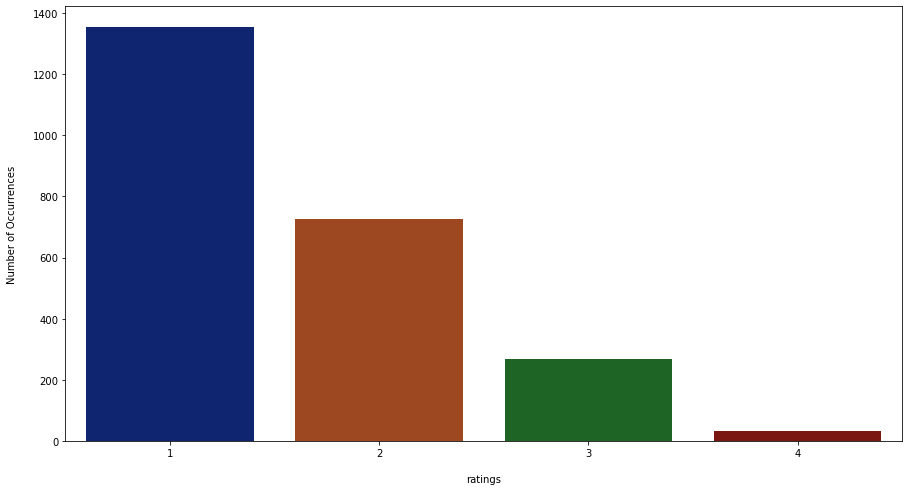

In [248]:
countplot("ratings")

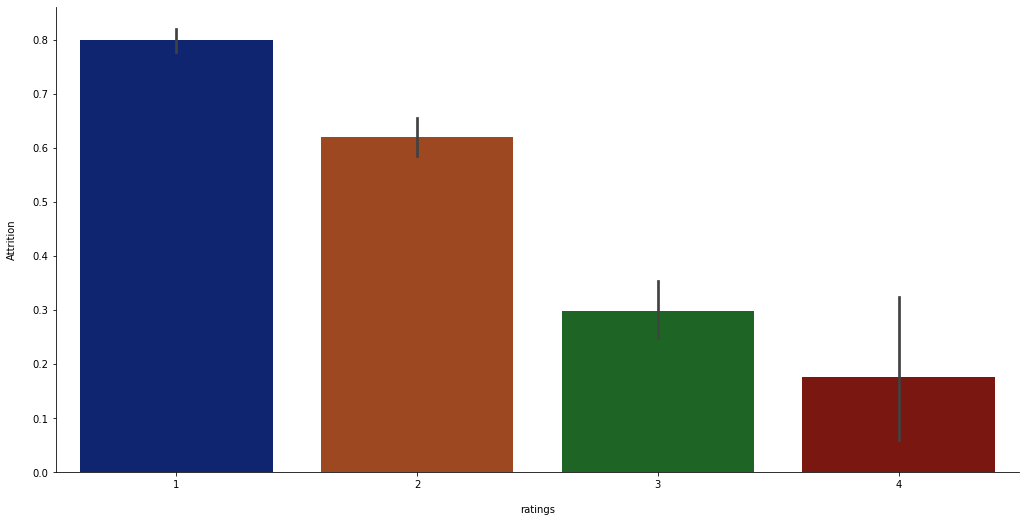

In [249]:
factorplot_bar("ratings")

In [250]:
type_ = ["Attrition", "No Attrition"]
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Pie(labels=type_, values=df['attrition'].value_counts(), name="Attrition"))

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Employee attrition (1: Attrition, 0:No Attrition)",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='attrition', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

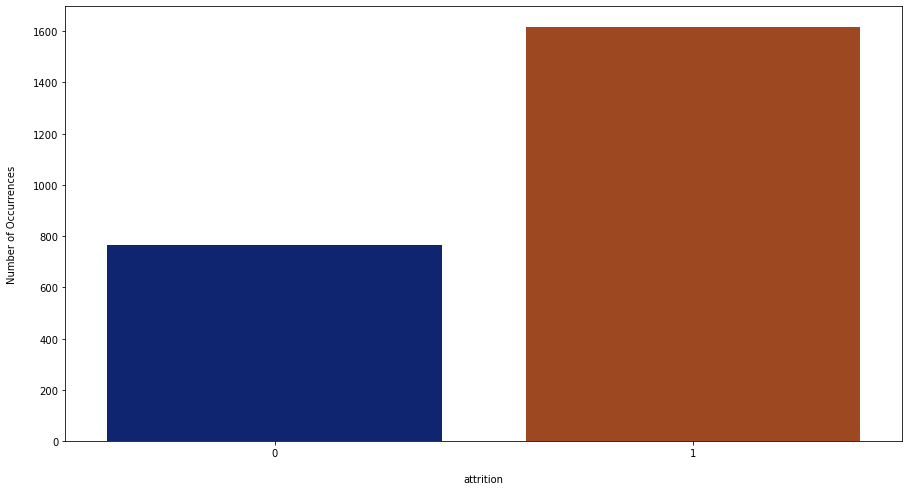

In [251]:
countplot("attrition")

In [252]:
attrition     = df[df["attrition"] == 1]
no_attrition = df[df["attrition"] == 0]

In [253]:
def histogram(column) :
    trace1 = go.Histogram(x  = attrition[column],
                          histnorm= "percent",
                          name = "Employee Attrition",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = no_attrition[column],
                          histnorm = "percent",
                          name = "No Attrition",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace2,trace1]
    layout = go.Layout(dict(title =column + " distribution in employee attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)

In [254]:
histogram("average_salary")

In [255]:
histogram("daysAtcompany")

In [256]:
attrition.columns

Index(['emp_id', 'age_joining', 'age_last', 'gender', 'city', 'education',
       'daysAtcompany', 'average_salary', 'percentage_hike', 'got_hike',
       'got_promoted', 'daysSince_promotion', 'noOf_promotions',
       'joining_designation', 'current_designation', 'avg_business_value',
       'ratings', 'attrition'],
      dtype='object')

In [257]:
df.average_salary.describe()

count      2381.000000
mean      59272.611088
std       28325.327533
min       10747.000000
25%       39104.000000
50%       55285.000000
75%       75835.000000
max      188418.000000
Name: average_salary, dtype: float64

In [258]:
df.daysAtcompany.describe()

count    2381.000000
mean      425.189416
std       563.931017
min         0.000000
25%        91.000000
50%       180.000000
75%       468.000000
max      2801.000000
Name: daysAtcompany, dtype: float64

In [259]:
#TODO

# 10k to 50k (Low), 500001 to80k (Medium), >800001 (high)


# Tenure at company :
#0-500 (Low) , 501-1500 (Medium), >1500 (High)

In [260]:
df.dtypes

emp_id                  int64
age_joining             int64
age_last                int64
gender                 object
city                   object
education              object
daysAtcompany           int64
average_salary          int64
percentage_hike         int64
got_hike                int64
got_promoted            int64
daysSince_promotion     int64
noOf_promotions         int64
joining_designation     int64
current_designation     int64
avg_business_value      int64
ratings                 int64
attrition               int64
dtype: object

In [261]:
numerical_features_ = df.describe(include=["int64"]).columns

print(list(numerical_features_))



['emp_id', 'age_joining', 'age_last', 'daysAtcompany', 'average_salary', 'percentage_hike', 'got_hike', 'got_promoted', 'daysSince_promotion', 'noOf_promotions', 'joining_designation', 'current_designation', 'avg_business_value', 'ratings', 'attrition']


In [262]:
categorical_features_ = df.describe(include=["object"]).columns

print(list(categorical_features_))

['gender', 'city', 'education']


In [263]:
"""sns.set_style('darkgrid')
sns.pairplot(df[numerical_features_[1:]])
plt.show()"""

"sns.set_style('darkgrid')\nsns.pairplot(df[numerical_features_[1:]])\nplt.show()"

In [1015]:
#!pip install imblearn




In [266]:
df = df[['emp_id', 'age_joining', 'age_last', 'gender','education','average_salary',
                             'daysAtcompany', 'got_hike', 'noOf_promotions', 'joining_designation',
                            'current_designation', 'avg_business_value', 'ratings', 'attrition']]

In [267]:


education_dict = {'College':1,'Bachelor':2, 'Master':3}


df["education"] = df["education"].apply(lambda x: education_dict[x])

In [268]:
df.head()

,emp_id,age_joining,age_last,gender,education,average_salary,daysAtcompany,got_hike,noOf_promotions,joining_designation,current_designation,avg_business_value,ratings,attrition
0,1,28,28,Male,3,57387,78,0,0,1,1,571860,2,1
1,2,31,31,Male,3,67016,25,0,0,2,2,0,1,0
2,4,43,43,Male,3,65603,141,0,0,2,2,70000,1,1
3,5,29,29,Male,1,46368,58,0,0,1,1,40120,1,1
4,6,31,31,Female,2,78728,123,0,0,3,3,253000,2,0


In [269]:
from sklearn.preprocessing import StandardScaler
#one hot encoding: gender and city
# One-Hot encoding 
data_copy= df.copy()
variables = ['gender']
data_copy = pd.get_dummies(data_copy, columns = variables, prefix = variables)


"""#label encoder
from sklearn.preprocessing import LabelEncoder


data_copy= df.copy()
le = LabelEncoder()
# Label Encoding will be used for columns with 2 or less unique values
le_count = 0
for col in data_copy[["city"]]:
    le.fit(data_copy[col])
    data_copy[col] = le.transform(data_copy[col])
    le_count += 1
print('{} columns were label encoded.'.format(le_count))"""

'#label encoder\nfrom sklearn.preprocessing import LabelEncoder\n\n\ndata_copy= df.copy()\nle = LabelEncoder()\n# Label Encoding will be used for columns with 2 or less unique values\nle_count = 0\nfor col in data_copy[["city"]]:\n    le.fit(data_copy[col])\n    data_copy[col] = le.transform(data_copy[col])\n    le_count += 1\nprint(\'{} columns were label encoded.\'.format(le_count))'

In [270]:
data_copy.head()

,emp_id,age_joining,age_last,education,average_salary,daysAtcompany,got_hike,noOf_promotions,joining_designation,current_designation,avg_business_value,ratings,attrition,gender_Female,gender_Male
0,1,28,28,3,57387,78,0,0,1,1,571860,2,1,0,1
1,2,31,31,3,67016,25,0,0,2,2,0,1,0,0,1
2,4,43,43,3,65603,141,0,0,2,2,70000,1,1,0,1
3,5,29,29,1,46368,58,0,0,1,1,40120,1,1,0,1
4,6,31,31,2,78728,123,0,0,3,3,253000,2,0,1,0


In [271]:
data_copy.columns

Index(['emp_id', 'age_joining', 'age_last', 'education', 'average_salary',
       'daysAtcompany', 'got_hike', 'noOf_promotions', 'joining_designation',
       'current_designation', 'avg_business_value', 'ratings', 'attrition',
       'gender_Female', 'gender_Male'],
      dtype='object')

Text(0.5, 1.0, 'Correlation with employee attrition \n')

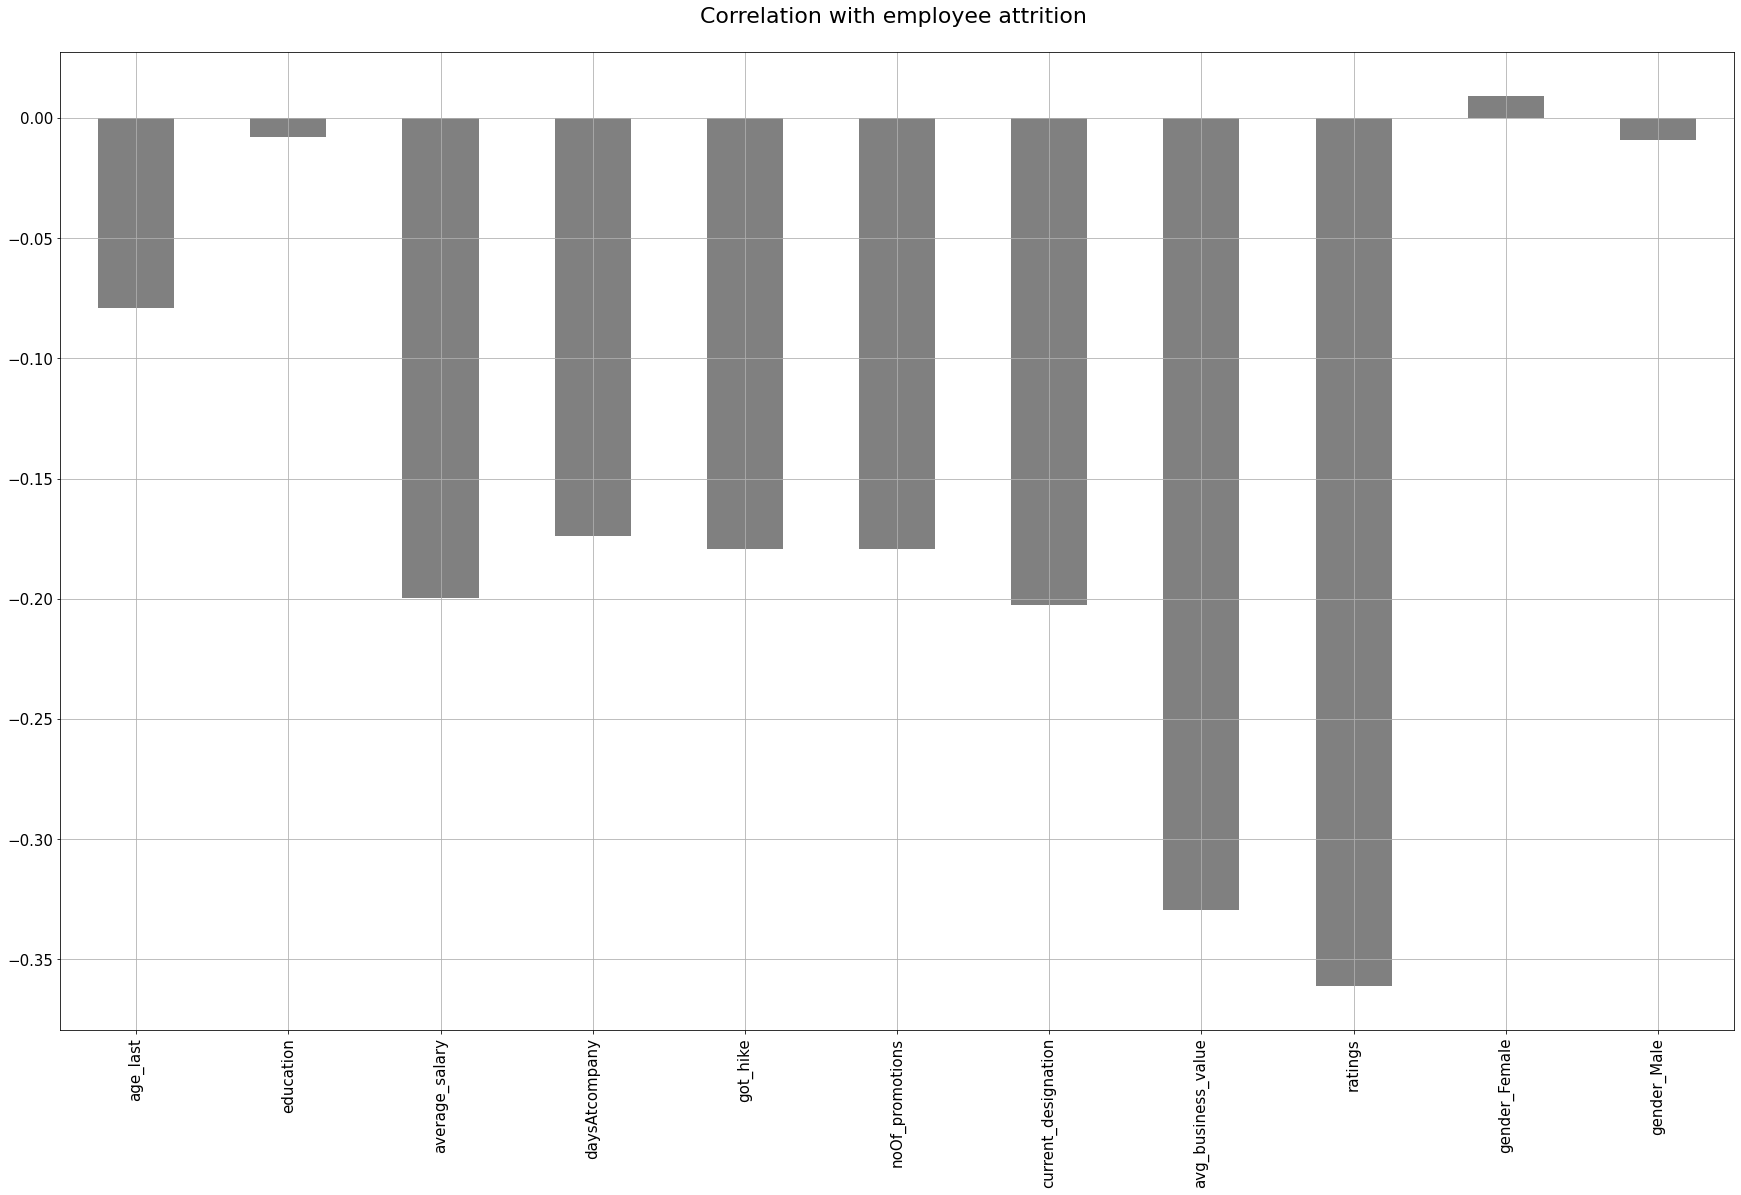

In [303]:
# correlation with attrition


data2 = data_copy[[ 'age_last', 'education', 'average_salary',
       'daysAtcompany', 'got_hike', 'noOf_promotions', 
       'current_designation', 'avg_business_value', 'ratings', 
       'gender_Female', 'gender_Male']]

correlations = data2.corrwith(data_copy["attrition"])
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (30, 18), 
        fontsize = 15, 
        color = 'grey',
        rot = 90, grid = True)
plt.title('Correlation with employee attrition \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

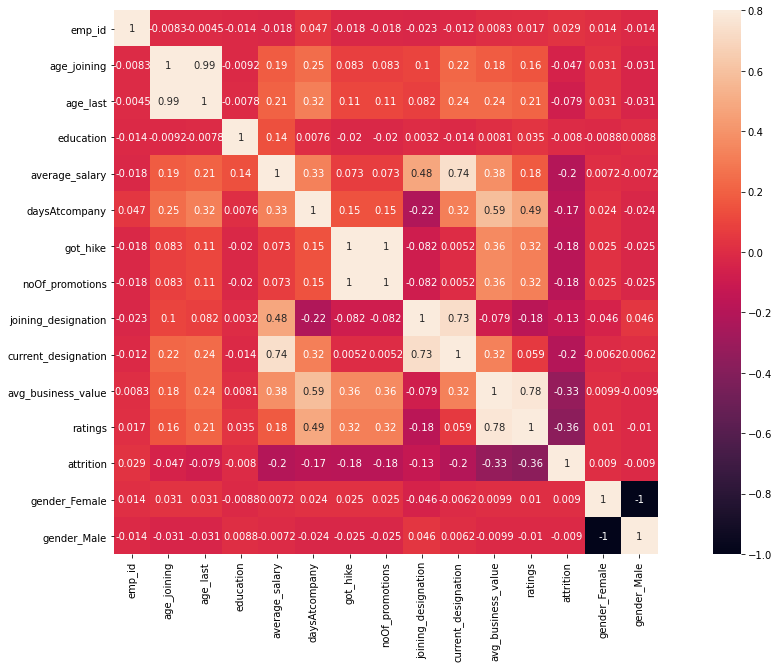

In [304]:
import seaborn as sns
import matplotlib.pyplot as pplt
#correlation matrix
corrmat = data_copy.corr()
f, ax = pplt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

#### Feature importance

In [388]:
y= data_copy.attrition
X = data_copy.drop(["attrition", "emp_id", "age_last"], axis= 1)



features_labels = X.columns



features_labels

Index(['age_joining', 'education', 'average_salary', 'daysAtcompany',
       'got_hike', 'noOf_promotions', 'joining_designation',
       'current_designation', 'avg_business_value', 'ratings', 'gender_Female',
       'gender_Male'],
      dtype='object')

In [389]:

RF = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
RF.fit(X,y)
features_imp = RF.feature_importances_

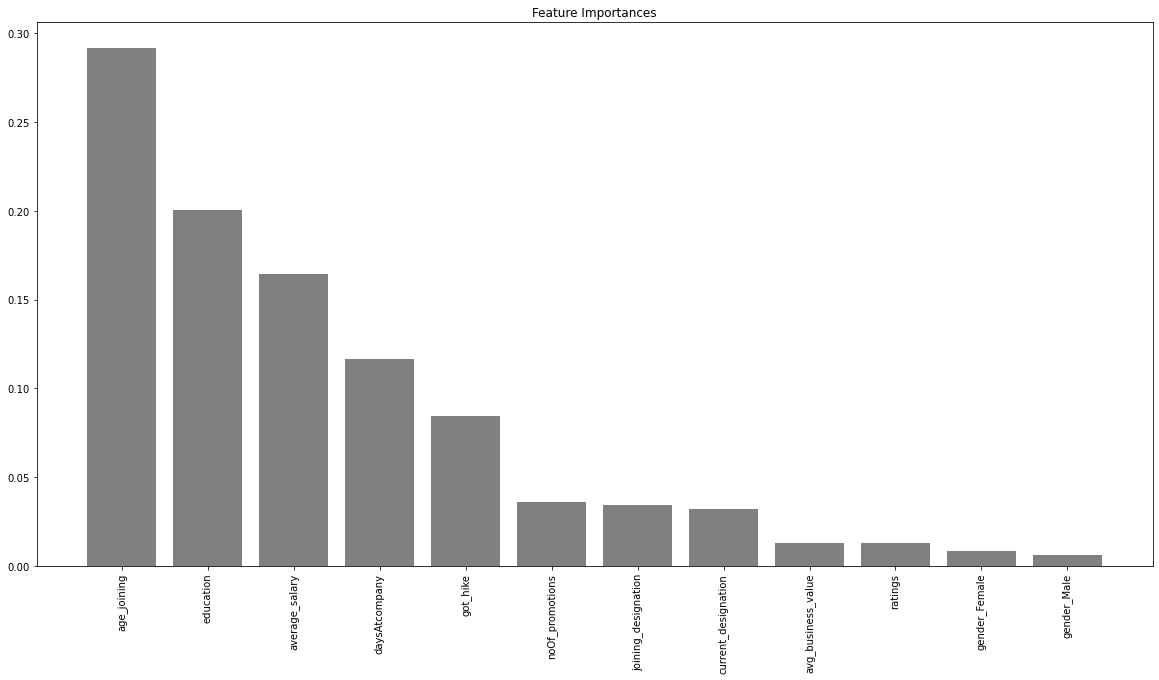

 1) age_joining                    0.291432
 2) education                      0.200277
 3) average_salary                 0.164230
 4) daysAtcompany                  0.116296
 5) got_hike                       0.084726
 6) noOf_promotions                0.035960
 7) joining_designation            0.034531
 8) current_designation            0.032378
 9) avg_business_value             0.012825
10) ratings                        0.012753
11) gender_Female                  0.008423
12) gender_Male                    0.006169


In [390]:
indices = np.argsort(features_imp)[::-1]
plt.subplots(figsize = (20,10)) 
# Visualization
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), features_imp[indices], color = "grey", align = "center")
plt.xticks(range(X.shape[1]), features_labels, rotation = 90)
plt.show()

for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_labels[i], features_imp[indices[i]]))
    

In [391]:
X.iloc[:,:9].columns

Index(['age_joining', 'education', 'average_salary', 'daysAtcompany',
       'got_hike', 'noOf_promotions', 'joining_designation',
       'current_designation', 'avg_business_value'],
      dtype='object')

In [392]:
# Imbalanced data handeling
#random_state=23,0

scaler = StandardScaler()
X = scaler.fit_transform(X.iloc[:,:10])

## Dealing with imbalanced dataset

In [393]:
from imblearn.over_sampling import SMOTE

In [394]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (1666, 10)
Number transactions y_train dataset:  (1666,)
Number transactions X_test dataset:  (715, 10)
Number transactions y_test dataset:  (715,)


In [395]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 1142
Before OverSampling, counts of label '0': 524 



In [396]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())


In [397]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

After OverSampling, the shape of train_X: (2284, 10)
After OverSampling, the shape of train_y: (2284,) 



In [398]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, counts of label '1': 1142
After OverSampling, counts of label '0': 1142


In [399]:
#Building the baseline models
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state=42)

In [400]:
#finding optimal number trees
score_array = []
for each in range(1,100):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1) 
    rf_loop.fit(X_train_res, y_train_res.ravel())
    score_array.append(rf_loop.score(X_test,y_test))
    

In [401]:
for i,j in enumerate(score_array):
    print(i+1,":",j)

1 : 0.6867132867132867
2 : 0.6223776223776224
3 : 0.73006993006993
4 : 0.7132867132867133
5 : 0.7510489510489511
6 : 0.7244755244755244
7 : 0.7538461538461538
8 : 0.7286713286713287
9 : 0.7496503496503496
10 : 0.7412587412587412
11 : 0.7482517482517482
12 : 0.7454545454545455
13 : 0.7566433566433567
14 : 0.7524475524475525
15 : 0.765034965034965
16 : 0.7538461538461538
17 : 0.7594405594405594
18 : 0.7594405594405594
19 : 0.7594405594405594
20 : 0.7608391608391608
21 : 0.765034965034965
22 : 0.7706293706293706
23 : 0.7748251748251749
24 : 0.7692307692307693
25 : 0.772027972027972
26 : 0.7636363636363637
27 : 0.7664335664335664
28 : 0.7664335664335664
29 : 0.7622377622377622
30 : 0.765034965034965
31 : 0.7692307692307693
32 : 0.772027972027972
33 : 0.7678321678321678
34 : 0.7706293706293706
35 : 0.7678321678321678
36 : 0.772027972027972
37 : 0.772027972027972
38 : 0.7706293706293706
39 : 0.772027972027972
40 : 0.7692307692307693
41 : 0.765034965034965
42 : 0.7678321678321678
43 : 0.77342

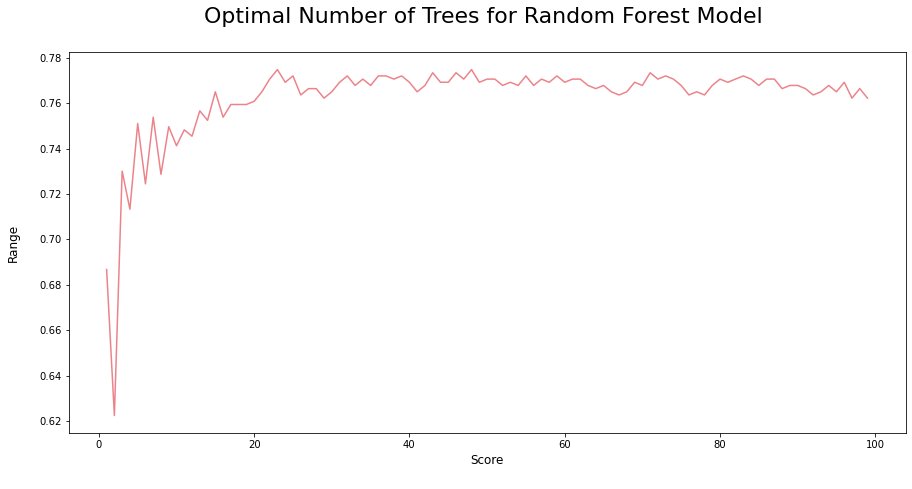

In [402]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,100),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

### Logistic Regression

In [403]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())


Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=5)

In [404]:
lr1 = LogisticRegression(C=4,penalty='l1', verbose=5, solver='liblinear')
lr1.fit(X_train_res, y_train_res.ravel())

[LibLinear]

LogisticRegression(C=4, penalty='l1', solver='liblinear', verbose=5)

In [405]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.plot()


Recall metric in the train dataset: 73.90542907180385%


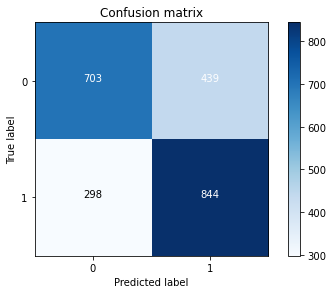

In [406]:
y_train_pre = lr1.predict(X_train_res)

cnf_matrix_tra = confusion_matrix(y_train_res, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

In [409]:
from sklearn.metrics import classification_report
#printing various metrics.
print(classification_report( y_train_res, y_train_pre))

              precision    recall  f1-score   support

           0       0.70      0.62      0.66      1142
           1       0.66      0.74      0.70      1142

    accuracy                           0.68      2284
   macro avg       0.68      0.68      0.68      2284
weighted avg       0.68      0.68      0.68      2284



In [410]:
#test
test_data  =pd.read_csv("test.csv")

test_emp_ids = test_data.Emp_ID.values
len(test_emp_ids)

test_ids = data_copy[data_copy['emp_id'].isin(test_emp_ids)]
test_ids.shape
test_ids.columns




Index(['emp_id', 'age_joining', 'age_last', 'education', 'average_salary',
       'daysAtcompany', 'got_hike', 'noOf_promotions', 'joining_designation',
       'current_designation', 'avg_business_value', 'ratings', 'attrition',
       'gender_Female', 'gender_Male'],
      dtype='object')

In [411]:


y_test_results = test_ids.attrition

test_ids.columns
X_test_data =test_ids[['age_joining', 'education', 'average_salary', 'daysAtcompany',
       'got_hike', 'noOf_promotions', 'current_designation','joining_designation',
       'avg_business_value', 'ratings']]
X_test_data

,age_joining,education,average_salary,daysAtcompany,got_hike,noOf_promotions,current_designation,joining_designation,avg_business_value,ratings
1,31,3,67016,25,0,0,2,2,0,1
4,31,2,78728,123,0,0,3,3,253000,2
6,28,3,42172,6,0,0,1,1,0,1
9,39,1,19734,46,0,0,3,3,0,1
17,29,2,102077,1128,0,0,3,1,1514630,4
...,...,...,...,...,...,...,...,...,...,...
2370,27,1,85112,60,0,0,3,3,0,1
2372,35,3,50180,2,0,0,2,2,0,1
2374,25,3,46952,287,0,0,2,2,784852,3
2376,33,1,82815,1873,0,0,3,2,906201,3


<AxesSubplot:>

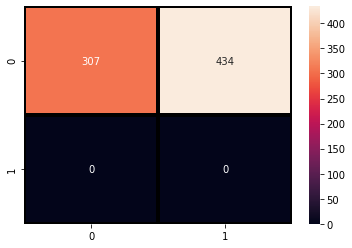

In [412]:



scaler_ = StandardScaler()
X_test_data = scaler_.fit_transform(X_test_data)


pred_lr1_test = lr1.predict(X_test_data)
#train data
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test_results, pred_lr1_test),annot=True,fmt = "d",linecolor="k",linewidths=3)

In [413]:
from sklearn.metrics import  accuracy_score
accuracy_final = accuracy_score(y_test_results,pred_lr1_test)
accuracy_final

0.4143049932523617

### Random Forest

In [414]:
#Random Forest
rf_test = {"max_depth": [4,6,8,10],
           "max_features": [6,8,10],
           "min_samples_split": [3,4,5],
           "min_samples_leaf": [3,4,5],
           "bootstrap": [True],
           "n_estimators" :[125],
           "criterion": ["gini","entropy"],
           "max_leaf_nodes":[20,22,24,26],
           "min_impurity_decrease":[0.0],
           "min_weight_fraction_leaf":[0.0]}

tuning = GridSearchCV(estimator = RandomForestClassifier(), param_grid = rf_test, scoring = 'accuracy', n_jobs = 6, cv = 5, verbose=1)

tuning.fit(X_train_res,np.ravel(y_train_res))

rf_best = tuning.best_estimator_

tuning.best_score_





Fitting 5 folds for each of 864 candidates, totalling 4320 fits


0.7950996199470229

In [419]:
tuning.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 10,
 'max_leaf_nodes': 26,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 125}

Recall metric in the train dataset: 73.90542907180385%


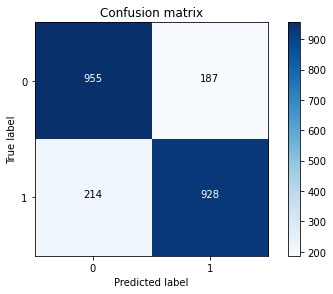

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1142
           1       0.83      0.81      0.82      1142

    accuracy                           0.82      2284
   macro avg       0.82      0.82      0.82      2284
weighted avg       0.82      0.82      0.82      2284



In [420]:
y_train_rf = rf_best.predict(X_train_res)

cnf_matrix_rf = confusion_matrix(y_train_res, y_train_rf)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_rf , classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
#printing various metrics.
print(classification_report( y_train_res, y_train_rf))





In [421]:
pred_rf_test = rf_best.predict(X_test_data)




0.6626180836707153

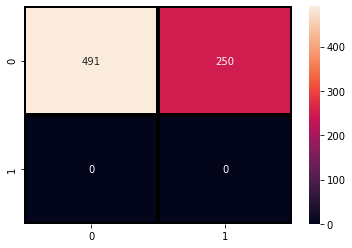

In [422]:
#train data
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test_results, pred_rf_test),annot=True,fmt = "d",linecolor="k",linewidths=3)

from sklearn.metrics import  accuracy_score
accuracy_final = accuracy_score(y_test_results,pred_rf_test)
accuracy_final





In [423]:
test_data["Target"] = pred_rf_test

test_data.to_csv("sumission_rftest2.csv")


## Selecting the classification model based on f1 score

In [424]:
from xgboost import XGBClassifier as XGBC
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB as GB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score, classification_report, precision_recall_curve,f1_score

In [425]:
def Classification_model(model,X_train_res,y_train_res,X_test,y_test): # here x is the variable which are used for prediction    # y is the supervision variable
   
    
    model.fit(X_train_res,y_train_res.ravel())
    pred=model.predict(X_test)
    accuracy=accuracy_score(y_test,pred)
    recall = recall_score(y_test,pred)
    precision = precision_score(y_test,pred)
    F1_score = f1_score(y_test,pred)
    return accuracy, recall, precision, F1_score




In [426]:
# Lets us make a list of models
models=["XGBClassifier","RandomForestClassifier","Gaussian Naive Bays","KNN","Logistic_Regression","Support_Vector"]
Classification_models = [XGBC(n_estimators=100),RandomForestClassifier(n_estimators=100),GB(),knn(n_neighbors=7),LogisticRegression(),SVC()]
Model_Accuracy = []
Model_Recall = []
Model_Precision = []
Model_f1 = []


In [427]:
for model in Classification_models:
    Accuracy,Recall, Precision, F1_score = Classification_model(model,X_train_res,y_train_res,X_test,y_test)    #,Recall, Precision, F1_score
    Model_Accuracy.append(Accuracy)
    Model_Recall.append(Recall)
    Model_Precision.append(Precision)
    Model_f1.append(F1_score)

[10:00:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [428]:
Accuracy_with_Imp_features = pd.DataFrame(
    { "Classification Model" :models,
     "Accuracy with Imp features":Model_Accuracy, "Recall with Imp features":Model_Recall, "Precision with Imp features":Model_Precision, 
     "F1 with Imp features":Model_f1})

In [429]:
Accuracy_with_Imp_features.sort_values(by="Accuracy with Imp features",ascending=False).reset_index(drop=True)

,Classification Model,Accuracy with Imp features,Recall with Imp features,Precision with Imp features,F1 with Imp features
0,XGBClassifier,0.783217,0.839662,0.834382,0.837014
1,RandomForestClassifier,0.770629,0.803797,0.842920,0.822894
2,Gaussian Naive Bays,0.734266,0.943038,0.732787,0.824723
3,Support_Vector,0.727273,0.744726,0.826698,0.783574
4,Logistic_Regression,0.721678,0.748945,0.816092,0.781078
5,KNN,0.678322,0.679325,0.805000,0.736842


xgboost seems to work well

## XGBoost: model1

In [431]:
# XGBOOSt
from xgboost import XGBClassifier
XGB = XGBClassifier()

xgb_param_grid = {'learning_rate': [0.1], 
                  'max_depth': [3,4],
                  'n_estimators': [130]}

gsXBC = GridSearchCV(XGB, param_grid = xgb_param_grid, cv = 5, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsXBC.fit(X_train_res,y_train_res)

xgb_best = gsXBC.best_estimator_

gsXBC.best_score_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[10:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8056086606011746

Recall metric in the train dataset: 89.92994746059544%


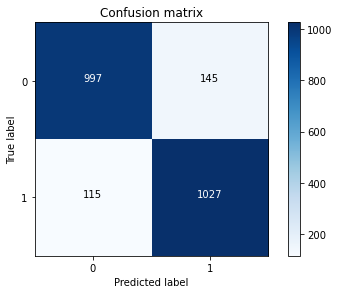

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1142
           1       0.88      0.90      0.89      1142

    accuracy                           0.89      2284
   macro avg       0.89      0.89      0.89      2284
weighted avg       0.89      0.89      0.89      2284



In [432]:
y_train_xgb = xgb_best.predict(X_train_res)

cnf_matrix_rgb = confusion_matrix(y_train_res, y_train_xgb)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_rgb[1,1]/(cnf_matrix_rgb[1,0]+cnf_matrix_rgb[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_rgb , classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
#printing various metrics.
print(classification_report( y_train_res, y_train_xgb))





In [434]:
#test

pred_xgb_test = xgb_best.predict(X_test_data)



0.7827260458839406

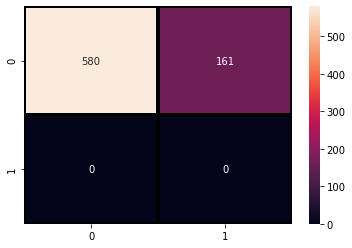

In [435]:

#train data
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test_results, pred_xgb_test),annot=True,fmt = "d",linecolor="k",linewidths=3)

from sklearn.metrics import  accuracy_score
accuracy_final = accuracy_score(y_test_results,pred_xgb_test)
accuracy_final





In [436]:
test_data["Target"] = pred_xgb_test

test_data.to_csv("sumission_xgbTest.csv")


## XGBOOSt:130: 57.044

### XGB model parameter tuning


In [449]:
# XGBOOSt
XGB = XGBClassifier()

xgb_param_grid = {'learning_rate': [0.2], 
                  'max_depth': [3,4,5],
                  'n_estimators': [131]}

gsXBC = GridSearchCV(XGB, param_grid = xgb_param_grid, cv = 5, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsXBC.fit(X_train_res,y_train_res)

xgb_best = gsXBC.best_estimator_

gsXBC.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[10:07:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8191811585857423

Recall metric in the train dataset: 96.58493870402802%


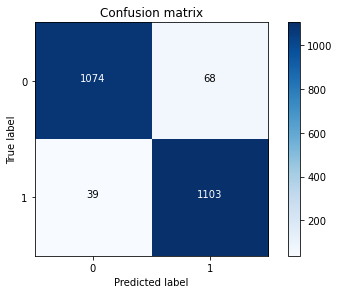

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1142
           1       0.94      0.97      0.95      1142

    accuracy                           0.95      2284
   macro avg       0.95      0.95      0.95      2284
weighted avg       0.95      0.95      0.95      2284



In [450]:
y_train_xgb = xgb_best.predict(X_train_res)

cnf_matrix_rgb = confusion_matrix(y_train_res, y_train_xgb)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_rgb[1,1]/(cnf_matrix_rgb[1,0]+cnf_matrix_rgb[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_rgb , classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
#printing various metrics.
print(classification_report( y_train_res, y_train_xgb))





In [452]:
#test

pred_xgb_test = xgb_best.predict(X_test_data)



0.8232118758434548

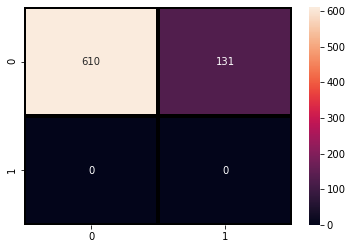

In [453]:

#train data
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test_results, pred_xgb_test),annot=True,fmt = "d",linecolor="k",linewidths=3)

from sklearn.metrics import  accuracy_score
accuracy_final = accuracy_score(y_test_results,pred_xgb_test)
accuracy_final



In [454]:
test_data["Target"] = pred_xgb_test

test_data.to_csv("sumission_xgbTest.csv")



## Final model with 61.20

In [463]:
# XGBOOSt
XGB = XGBClassifier()

xgb_param_grid = {'learning_rate': [0.1], 
                  'max_depth': [3,4,5],
                  'n_estimators': [200]}

gsXBC = GridSearchCV(XGB, param_grid = xgb_param_grid, cv = 5, scoring = "accuracy", n_jobs = 6, verbose = 1)

gsXBC.fit(X_train_res,y_train_res)

xgb_best = gsXBC.best_estimator_

gsXBC.best_score_



Fitting 5 folds for each of 3 candidates, totalling 15 fits
[10:10:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.812172252293754

Recall metric in the train dataset: 97.28546409807356%


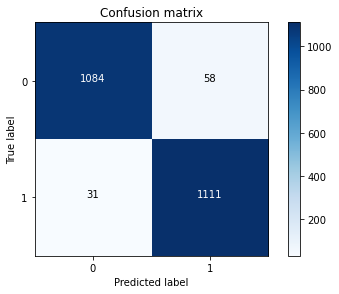

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1142
           1       0.95      0.97      0.96      1142

    accuracy                           0.96      2284
   macro avg       0.96      0.96      0.96      2284
weighted avg       0.96      0.96      0.96      2284



In [464]:
y_train_xgb = xgb_best.predict(X_train_res)

cnf_matrix_rgb = confusion_matrix(y_train_res, y_train_xgb)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_rgb[1,1]/(cnf_matrix_rgb[1,0]+cnf_matrix_rgb[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_rgb , classes=class_names, title='Confusion matrix')
plt.show()

from sklearn.metrics import classification_report
#printing various metrics.
print(classification_report( y_train_res, y_train_xgb))







In [465]:
#test


pred_xgb_test = xgb_best.predict(X_test_data)


0.8232118758434548

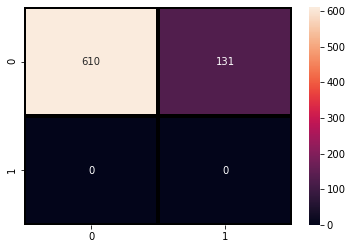

In [466]:
#train data
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test_results, pred_xgb_test),annot=True,fmt = "d",linecolor="k",linewidths=3)

from sklearn.metrics import  accuracy_score
accuracy_final = accuracy_score(y_test_results,pred_xgb_test)
accuracy_final




### Output file

In [467]:

test_data["Target"] = pred_xgb_test

test_data.to_csv("sumission_xgbTest.csv")






In [ ]:
"""
from sklearn.ensemble import GradientBoostingClassifier
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=160, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train_res, y_train_res)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_res, y_train_res)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()"""